# Deep Dream seminar

<a href="https://colab.research.google.com/github/ichko/ml-playground/blob/master/dream-seminar/02-deep-dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Let's start with some imports

In [1]:
# Standard library
import requests
import io

# PyTroch Stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# Common
from IPython.display import clear_output

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

clear_output()

In [2]:
torch.__version__

'1.6.0'

## First we need a pre-trained model

In [68]:
model = torchvision.models.inception_v3(pretrained=True, progress=True)
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [4]:
# We don't want to classify, we only need to extract some internal activations
feature_extractor = model.features

## Lets define some utilities for working with images

In [5]:
def load_image(url):
    response = requests.get(url)
    bytes_im = io.BytesIO(response.content)
    return cv2.cvtColor(np.array(Image.open(bytes_im)), cv2.COLOR_BGR2BGRA)[...,:3] / 255


mean = np.array([0.485, 0.456, 0.406]) 
std = np.array([0.229, 0.224, 0.225])
normalize = transforms.Compose([transforms.Normalize(mean, std)])


def preprocess(img, scale=1):
    img = img[...,:3].transpose(2, 0, 1)
    img = normalize(torch.Tensor(img)).unsqueeze(dim=0)
    return img


def postprocess(img):
    img = img[0].permute(1, 2, 0)
    img = img.detach().cpu().numpy()
    img = img * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    return img.clip(0, 1)


def show_image(img):
    img = (img * 255).astype(np.uint8)
    return Image.fromarray(img)

## Lets load an example image for deep dreaming

In [6]:
the_girl = 'https://image.slidesharecdn.com/nationalgeographic50bestphotographs-130812140426-phpapp02/95/national-geographic-50-best-photographs-1-638.jpg?cb=1376401598'
alex = 'https://news.itmo.ru/images/news/big/p8881.jpg'
nakov_nightmare = 'https://libertybits.org/wp-content/uploads/2018/01/IMG_1191-400x400.jpg'
nakov_twitter = 'https://pbs.twimg.com/profile_images/1069674276821889025/XOjpmZbY_400x400.jpg'
yambol = 'https://www.hotelyambol.com/wp-content/uploads/2018/01/bezisten-1024x575.jpg'
mc_escher = 'https://cdn-cijoc.nitrocdn.com/fRozZUmSsdrcaxPjfQFSBxHbCQLINOEX/assets/static/optimized/rev-92f2f4e/wp-content/uploads/2021/04/M-C-Escher-Hand-with-Reflecting-Sphere-1935.jpg'
pollock = 'https://www.moma.org/media/W1siZiIsIjQ3ODMxNyJdLFsicCIsImNvbnZlcnQiLCItcXVhbGl0eSA5MCAtcmVzaXplIDIwMDB4MjAwMFx1MDAzZSJdXQ.jpg?sha=7e9ab11fb155fe3b'
salvador = 'https://www.hagiospress.com/wp-content/uploads/2020/02/The-Persistence-of-Memory.jpg'
kahlo = 'https://i.guim.co.uk/img/media/8d1483b028d86d43b7d17f01bd808d116df5555c/0_394_2251_1350/master/2251.jpg?width=1020&quality=85&auto=format&fit=max&s=5741e6118f7de295e3507d731a5dfd5a'
mandelbrot = 'https://i.stack.imgur.com/ER6mQ.jpg'
st_petersburg = 'https://cdnp.flypgs.com/files/Sehirler-long-tail/St_Petersburg/st-petersburg-gezi-rehberi.jpg'

In [53]:
url = alex
np_im = load_image(url)
pil_im = show_image(np_im)
# pil_im

In [8]:
n_im = preprocess(np_im)
n_im.shape, n_im.min(), n_im.max()

(torch.Size([1, 3, 533, 800]), tensor(-2.1179), tensor(2.6400))

In [9]:
post_im = postprocess(n_im)
post_im.shape, post_im.min(), post_im.max()

((533, 800, 3), 0.0, 1.0)

## Dreaming up multiple steps of details

In [50]:
def dream(model, inp, lr, its, show_progress=True):
#     model.eval()
    
    inp = inp.clone()
    inp = torch.autograd.Variable(inp, requires_grad=True)

    for i in tqdm(range(its), disable=not show_progress):
        model.zero_grad()
        features = model(inp)
        norm = features.norm(p=2)
        norm.backward()

        mean_grad = inp.grad.abs().mean()
        detail = inp.grad.data / mean_grad * lr
        inp.data += detail
        inp.grad.zero_()

    return inp

In [56]:
url = the_girl
np_im = load_image(url)
pil_im = show_image(np_im)
# pil_im
np_im.shape

(479, 638, 3)

In [57]:
H, W = np_im.shape[:2]
ar = H / W

In [58]:
# Resize
W = 700
H = int(ar * W)
np_im = cv2.resize(np_im, (W, H))

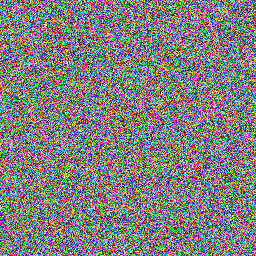

In [59]:
# or load some randomness
np.random.seed(88)
np_im = np.random.rand(256, 256, 3)
show_image(np_im)

In [60]:
n_im = preprocess(np_im)
n_im.shape, n_im.min(), n_im.max()

(torch.Size([1, 3, 256, 256]), tensor(-2.1179), tensor(2.6400))

__Dreaming it up__

In [74]:
# o_inp = preprocess(np.random.rand(256, 256, 3)).to(DEVICE)
o_inp = preprocess(np_im).to(DEVICE)

model = model.to(DEVICE)
model = model.eval()
detail = torch.zeros_like(o_inp).to(DEVICE)

H, W = o_inp.shape[-2:]

steps = 10
for i in tqdm(range(steps)):
    init_scale = 0.2
    scale = init_scale + (1 - init_scale) * (i / (steps - 1))

    H_scale, W_scale = int(H * scale), int(W * scale)
    interp_inp = F.interpolate(o_inp, (H_scale, W_scale), mode='bilinear', align_corners=True)
    detail = F.interpolate(detail, (H_scale, W_scale), mode='bilinear', align_corners=True)

    inp = (interp_inp + detail).repeat(2, 1, 1, 1)
    inp = dream(model, inp, lr=0.1, its=50, show_progress=False)
    detail =  inp.data - interp_inp

    out = postprocess(interp_inp + detail)
    display(show_image(out))

Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f6b785842d0>
Traceback (most recent call last):
  File "/home/izpc/anaconda3/lib/python3.7/site-packages/tqdm/notebook.py", line 222, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

---
And that's basically it! Pretty cool, huh 😎